In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

def normal_1d(mu, sigma, x):
    """ Unidimensional normal with mu mean value and sigma the dispersion """
    """ All three elements must be floats """

    normal = 1 / np.sqrt(2 * np.pi * sigma ) * math.exp(-1 / (2 * sigma) * (x - mu) **2)

    return normal



def normal_kd(theta_list, pres_list, x_list):
    """ Multivariate normal of dimension k, the lenght of x  """
    """ The theta is the vector of mean values while sigma is the precision matrix """
    """ All three elements must be lists, the sigma is a list containing the elements in the diagonal, only diagonal allowed """

    x = np.asarray(x_list)
    theta = np.asarray(theta_list)
    diag_array = np.asarray(pres_list)
    pres = np.diag(diag_array)

    k = len(x)
    dif = np.subtract(x, theta)
    #print('dif=', dif)
    #pres = np.linalg.inv(sigma)
    if np.linalg.det(pres) < 0:
        print('DET UNDER ZERO!!')
        print('pres=', pres)
        print('exponencial=', -1/2 * (np.matmul(dif, np.matmul(pres, dif))))
    normal = 1 / np.sqrt( (2 * np.pi) **k * abs(np.linalg.det(pres))) * math.exp(np.float128(-1/2 * (np.matmul(dif, np.matmul(pres, dif)))) )

    return normal


def ink(k, n, x, s, l, params):

    xn = x[n]
    sn = s[n]
    ln = l[n]
    wk = params.param_dict['w'][-1][k]
    thetak = params.param_dict['theta'][-1][k]
    phik = params.param_dict['phi_pres'][-1][k]
    muTk = params.param_dict['muT'][-1][k]
    muNk = params.param_dict['muN'][-1][k]
    lambk = params.param_dict['lamb'][-1][k]

    #print(phik)
    #print(thetak)
    #print(xn)

    N1 = normal_kd(thetak, phik, xn)
    N2 = normal_1d(muTk, float(lambk)**(-1), sn)
    N3 = normal_1d(muNk, float(lambk)**(-1), sn)

    i = wk * N1 * (N2 ** (ln)) * (N3 ** (1-ln))

    return wk, N1, N2, N3, ln, i


def zeta(i_nk):

    n = len(i_nk)
    k = len(i_nk[0])
    z_nk = np.zeros((n,k))


    for nn in range(n):
        i_sum = sum(i_nk[nn])
    
        z_nk[nn] = i_nk[nn] / i_sum

    return z_nk

def accumulated_params(z, l, s, x):

    n = len(z)
    k = len(z[0])
    auxn1 = np.zeros((n,k))
    auxn0 = np.zeros((n,k))
    auxr1 = np.zeros((n,k))
    auxr0 = np.zeros((n,k))
    auxr = np.zeros((n,k))

    for nn in range(n):
        auxn1[nn] = z[nn] * l[nn]
        auxn0[nn] = z[nn] * (1 - l[nn])
        auxr1[nn] = z[nn] * l[nn] * s[nn]
        auxr0[nn] = z[nn] * (1 - l[nn]) * s[nn]
        auxr[nn] = z[nn] * s[nn] * s[nn]

    nx = len(x[0])
    auxrx = np.zeros((k,nx))

    for kk in range(k):
        count = np.zeros(nx)
        for nn in range(n):
            #print(cuenta, z[nn,kk]*x[nn])
            count = count + z[nn,kk]*x[nn]
        auxrx[kk] = count

    auxrxx = np.zeros((k,nx))

    for kk in range(k):
        count2 = np.zeros(nx)
        for nn in range(n):
            #print(cuenta, z[nn,kk]*x[nn])
            count2 = count2 + z[nn,kk]*x[nn]*x[nn]
        auxrxx[kk] = count2


    N1 = np.sum(auxn1,axis=0) 
    N0 = np.sum(auxn0,axis=0)
    r1 = np.sum(auxr1,axis=0) 
    r0 = np.sum(auxr0,axis=0) 
    r = np.sum(auxr,axis=0) 
    rx = auxrx 
    rxx = auxrxx

        

    return N1, N0, r1, r0, r, rx, rxx


def Q_func(params, N1, N0, r1, r0, r, rx, rxx, N, D):


    phi_mat = []
    for kk in range(len(params.param_dict['phi_pres'][-1])):
        phi_mat.append(np.diag(params.param_dict['phi_pres'][-1][kk]))

    Q1 = - N/2 * (1+ 2*D) * np.log(2*np.pi) + np.log(params.param_dict['rho'][-1]) * sum(N1) 
    Q2 = np.log(1-params.param_dict['rho'][-1]) * sum(N0) + 0.5* sum((N1 + N0) * (2*np.log(params.param_dict['w'][-1]) + np.log(params.param_dict['lamb'][-1]) + np.log(np.linalg.det(phi_mat)))) 
    Q3 = -0.5* sum(params.param_dict['lamb'][-1] * (r -2* r1 * params.param_dict['muT'][-1] -2* r0 * params.param_dict['muN'][-1] + N1 * params.param_dict['muT'][-1] * params.param_dict['muT'][-1] + N0 * params.param_dict['muN'][-1] * params.param_dict['muN'][-1])) 
    Q4 = -0.5 * sum(sum(params.param_dict['phi_pres'][-1] *(rxx - 2 * rx * params.param_dict['theta'][-1] + np.transpose((N1+N0) * np.transpose(params.param_dict['theta'][-1] * params.param_dict['theta'][-1]))))) 
    Q = Q1 + Q2 + Q3 + Q4

    return Q/N, Q1/N, Q2/N, Q3/N, Q4/N

def param_update(params, N1, N0, r1, r0, r, rx, rxx, kappa=0.001):

    k = len(N1)
    n = len(params.param_dict['theta'][-1][0])
    muT = np.zeros((k))
    muN = np.zeros((k))
    lamb = np.zeros((k))
    theta = np.zeros((k,n))
    phi = np.zeros((k,n))



    rho = sum(N1) / sum(N1+N0)
    w = (N1+N0) / sum(N1+N0)
    
    for kk in range(k):
        muT[kk] = r1[kk] / N1[kk]
        muN[kk] = r0[kk] / N0[kk]
        lamb[kk] = (N1[kk] + N0[kk]) / (r[kk] - N1[kk] * params.param_dict['muT'][-1][kk] - N0[kk] * params.param_dict['muN'][-1][kk])
        theta[kk] = rx[kk] / (N1[kk] + N0[kk] + kappa)
        phi[kk] = np.divide((N1[kk] + N0[kk]) * np.ones(n), rxx[kk] - (N1[kk] + N0[kk])*  (params.param_dict['theta'][-1][kk] * params.param_dict['theta'][-1][kk]))


    return rho, w, muT, muN, lamb, theta, phi

    


In [2]:
### prueba de la clase

import gca_math as gcamath

model_par = gcamath.par()
model_par.load()

N = 5
for i in range(N):
    model_par.iter()

print(model_par.phi)

[12, 12, 12, 12, 12, 12]


In [2]:
###importar parametros

import gca_math as gcamath
import numpy as np

modelparam = gcamath.calculate_params()
modelparam.load_params('/home/mariel/dcaplda-repo/GCA-PLDA/speaker_verification/configs/gca_train/param_card.yaml')
#modelparam.iter()

print('nx=', modelparam.param_dict['nx'])
print('k=', modelparam.param_dict['k'])
print('w=', modelparam.param_dict['w'][-1])
print('w=', modelparam.param_dict['w'])
print('muT=', modelparam.param_dict['muT'][-1])
print('muN=', modelparam.param_dict['muN'][-1])
print('theta=', modelparam.param_dict['theta'][-1])
print('rho=', modelparam.param_dict['rho'])
print('phi=', modelparam.param_dict['phi_pres'][-1])
print('lamb=', modelparam.param_dict['lamb'][-1])

Q_list = []

#N = 5
#for i in range(N):
#    modelparam.iter()

#print('lamb', modelparam.param_dict['lamb'])




nx= 20
k= 1
w= [0.5296398]
w= [array([0.5296398])]
muT= [1]
muN= [-1]
theta= [[-0.01287283 -0.01220391 -0.04029451 -0.03421898  0.03680862  0.01479503
   0.01884074 -0.05446962  0.15139032  0.04688374  0.0762512  -0.09038224
   0.13361764  0.04271724  0.04100337 -0.08231193  0.04289624  0.07311891
  -0.07358795  0.13738159]]
rho= [0.2]
phi= [[0.0003 0.0003 0.0003 0.0003 0.0003 0.0003 0.0003 0.0003 0.0003 0.0003
  0.0003 0.0003 0.0003 0.0003 0.0003 0.0003 0.0003 0.0003 0.0003 0.0003]]
lamb= [1]


In [3]:
### importar datos

import gca_utils
from sklearn.decomposition import PCA


table_dir = "/home/mariel/dcaplda-repo/GCA-PLDA/speaker_verification/output/voxceleb2_dev/models/data_table.h5"
n_pca = 10
enroll_ids, test_ids, key, score, emb1, emb2 = gca_utils.load_data_table(table_dir)

#this is what train function does (so far...)
n_pca = int(n_pca)
pca = PCA(n_components=n_pca)

emb1_red = pca.fit_transform(emb1)
emb2_red = pca.fit_transform(emb2)

con = np.concatenate((emb1_red, emb2_red), axis=1)
n = len(con)
k = modelparam.param_dict['k']
###

### chequeos estadisticos para ver varianza y media de los embeddings concatenados
#mean = []
#for j in range(len(con[0])):
#    aux = 0
#    for n in range(len(con[:2000])):
    
        #print(con[n][j])
#        aux = aux + con[n][j]
#    mean.append(aux/20)

#print(mean)

#from statistics import pvariance

#print(pvariance(mean))

#s = np.random.normal(0, 50, 20)
#print(s)
#######




In [4]:
#### para iterar correr desde ACA

for j in range(3):
    i_array = np.zeros((n,k))
    for nn in range(n):
        for kk in range(k):
            wk, N1, N2, N3, ln, i_array[nn,kk] = ink(kk, nn, con, score, key, modelparam)

            
    zetank = zeta(i_array)

    N1, N0, r1, r0, r, rx, rxx = accumulated_params(zetank, key, score, con)

    #print('N1=', N1)
    #print('N0=', N0)
    #print('r1=', r1)
    #print('r0=', r0)
    #print('r=', r)
    #print('rx=', rx)
    #print('rxx=', rxx)

    D = n_pca
    N_emb = len(con)

    #print(modelparam.param_dict['rho'])
    Q, q1, q2, q3, q4= Q_func(modelparam, N1, N0, r1, r0, r, rx, rxx, N_emb, D)

    print(Q)

    rho2, w2, mut2, mun2, lamb2, theta2, phi2 = param_update(modelparam, N1, N0, r1, r0, r, rx, rxx)

    modelparam.param_dict['w'].append(w2)
    modelparam.param_dict['muT'].append(mut2)
    modelparam.param_dict['muN'].append(mun2)
    modelparam.param_dict['lamb'].append(lamb2)
    modelparam.param_dict['phi_pres'].append(phi2)
    modelparam.param_dict['rho'].append(rho2)
    modelparam.param_dict['theta'].append(theta2)

    Q_list.append(Q)

    print('iteracion nro=', j)
print('Q=', Q_list)
print('w=', modelparam.param_dict['w'])
print('muT=', modelparam.param_dict['muT'])
print('muN=', modelparam.param_dict['muN'])
print('lamb=', modelparam.param_dict['lamb'])
print('phi=', modelparam.param_dict['phi_pres'])
print('rho=', modelparam.param_dict['rho'])
print('theta=', modelparam.param_dict['theta'])



-136.4604594464238
iteracion nro= 0
-92.4928985767024
iteracion nro= 1
-92.51323929604715
iteracion nro= 2
Q= [-136.4604594464238, -92.4928985767024, -92.51323929604715]
w= [array([0.5296398]), array([1.]), array([1.]), array([1.])]
muT= [array([1]), array([6.88764874]), array([6.88764874]), array([6.88764874])]
muN= [array([-1]), array([-8.03008868]), array([-8.03008868]), array([-8.03008868])]
lamb= [array([1]), array([0.01229431]), array([0.01165722]), array([0.01165722])]
phi= [array([[0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
        0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
        0.0003, 0.0003, 0.0003, 0.0003]]), array([[0.00035847, 0.00153274, 0.00169784, 0.0020409 , 0.00210791,
        0.0030147 , 0.00380213, 0.00431301, 0.00541165, 0.0057974 ,
        0.00037222, 0.00160476, 0.00175877, 0.0019706 , 0.00211827,
        0.00274298, 0.00331827, 0.00460431, 0.00516313, 0.00614152]]), array([[0.00035847, 0.00153274, 0.00169784, 0.00204

In [1]:
###importar parametros

import gca_math as gcamath
import numpy as np

modelparam = gcamath.calculate_params()
modelparam.load_params('/home/mariel/dcaplda-repo/GCA-PLDA/speaker_verification/configs/gca_train/param_card.yaml')
#modelparam.iter()

print('nx=', modelparam.param_dict['nx'])
print('k=', modelparam.param_dict['k'])
print('w=', modelparam.param_dict['w'][-1])
print('w=', modelparam.param_dict['w'])
print('muT=', modelparam.param_dict['muT'][-1])
print('muN=', modelparam.param_dict['muN'][-1])
print('theta=', modelparam.param_dict['theta'][-1])
print('rho=', modelparam.param_dict['rho'])
print('phi=', modelparam.param_dict['phi_pres'][-1])
print('lamb=', modelparam.param_dict['lamb'][-1])

### importar datos

import gca_utils
from sklearn.decomposition import PCA


table_dir = "/home/mariel/dcaplda-repo/GCA-PLDA/speaker_verification/output/voxceleb2_dev/models/data_table.h5"
n_pca = modelparam.param_dict['nx']/2
enroll_ids, test_ids, key, score, emb1, emb2 = gca_utils.load_data_table(table_dir)

#this is what train function does (so far...)
n_pca = int(n_pca)
pca = PCA(n_components=n_pca)

emb1_red = pca.fit_transform(emb1)
emb2_red = pca.fit_transform(emb2)

con = np.concatenate((emb1_red, emb2_red), axis=1)
#n = len(con)
#k = modelparam.param_dict['k']

modelparam.iter(3, con, score, key)

nx= 20
k= 1
w= [0.0544614]
w= [array([0.0544614])]
muT= [1]
muN= [-1]
theta= [[ 0.08204152  0.01530076  0.23038179  0.13179143 -0.16356126 -0.05153342
   0.15582613 -0.02846675 -0.05621256 -0.02354863  0.007279    0.04036863
  -0.1403364  -0.11657544  0.07501549  0.03457808 -0.00456361 -0.00439255
   0.03736696  0.01302771]]
rho= [0.2]
phi= [[0.0003 0.0003 0.0003 0.0003 0.0003 0.0003 0.0003 0.0003 0.0003 0.0003
  0.0003 0.0003 0.0003 0.0003 0.0003 0.0003 0.0003 0.0003 0.0003 0.0003]]
lamb= [1]
-157.1139459447651
iteracion nro= 0
-110.8716695691924
iteracion nro= 1
-110.89201029066908
iteracion nro= 2
Q= [-157.1139459447651, -110.8716695691924, -110.89201029066908]
w= [array([0.0544614]), array([1.]), array([1.]), array([1.])]
muT= [array([1]), array([6.88764874]), array([6.88764874]), array([6.88764874])]
muN= [array([-1]), array([-8.03008868]), array([-8.03008868]), array([-8.03008868])]
lamb= [array([1]), array([0.01229431]), array([0.01165722]), array([0.01165722])]
phi= [array([[0.

In [38]:
#### para iterar correr desde ACA

#n = 5 #el real esta arriba, este es para no correr los 25 mil ns
#k = 3
i_array = np.zeros((n,k))
for nn in range(n):
    for kk in range(k):
        wk, N1, N2, N3, ln, i_array[nn,kk] = ink(kk, nn, con, score, key, modelparam)

        
zetank = zeta(i_array)

N1, N0, r1, r0, r, rx, rxx = accumulated_params(zetank, key, score, con)

print('N1=', N1)
print('N0=', N0)
print('r1=', r1)
print('r0=', r0)
print('r=', r)
print('rx=', rx)
print('rxx=', rxx)

D = n_pca
N_emb = len(con)

N1= [130.41232671 205.54450337 628.22808575  53.66450525  75.50813127
 952.05556357 119.52669373 240.5386052   16.06479447 739.38948689
 738.78851107 130.36393064  93.53449421 405.35949085 400.05839555
  69.96248148]
N0= [ 544.9045528   839.06061605 1976.52763143  191.32984032  312.93105052
 4101.47157804  499.18156069 1030.41112382   54.68175424 3122.76336647
 2977.98815159  441.39302713  390.13731171 1725.78499481 1569.61542123
  205.81801916]
r1= [ 881.07352867 1412.12594795 4553.80644491  376.61138782  518.51472167
 6590.99701182  798.44969965 1616.08775301  110.80483647 5038.25436672
 4936.56995864  899.9007104   656.99747916 2816.99741831 2730.37956563
  493.78522252]
r0= [ -4245.43894508  -6475.82749571 -13604.60996761  -1373.52239239
  -2434.60492906 -32859.6438875   -3963.23857612  -8681.14941008
   -381.44578176 -26304.34527032 -25555.89016181  -3009.88056759
  -3173.76503981 -13733.28831629 -13381.13639108  -1295.50506371]
r= [ 51862.06869757  79237.85254847 170354.22632834 

In [54]:
z = np.array([[1,5,3],[1,5,8]])
l = [2,3]

n = len(z)
#print(n)
k = len(z[0])
aux = np.zeros((n,k))

#print(type(N))
suma = np.sum(z,axis=0) 

#print(suma)
for nn in range(n):
    aux[nn] = z[nn] * l[nn]

suma = np.sum(aux,axis=0) 
#print(suma)

#print(N1(z,l))

x = np.array([[1,2,3,4,5],[6,7,8,9,10]])

auxrx = np.zeros((k,len(x[0])))

print(x[1])

for kk in range(k):
    cuenta = np.zeros(5)
    for nn in range(n):
        print(cuenta, z[nn,kk]*x[nn])
        cuenta = cuenta + z[nn,kk]*x[nn]
        print('x=',x[nn]*x[nn])
    auxrx[kk] = cuenta

print(auxrx)



[ 6  7  8  9 10]
[0. 0. 0. 0. 0.] [1 2 3 4 5]
x= [ 1  4  9 16 25]
[1. 2. 3. 4. 5.] [ 6  7  8  9 10]
x= [ 36  49  64  81 100]
[0. 0. 0. 0. 0.] [ 5 10 15 20 25]
x= [ 1  4  9 16 25]
[ 5. 10. 15. 20. 25.] [30 35 40 45 50]
x= [ 36  49  64  81 100]
[0. 0. 0. 0. 0.] [ 3  6  9 12 15]
x= [ 1  4  9 16 25]
[ 3.  6.  9. 12. 15.] [48 56 64 72 80]
x= [ 36  49  64  81 100]
[[ 7.  9. 11. 13. 15.]
 [35. 45. 55. 65. 75.]
 [51. 62. 73. 84. 95.]]


In [30]:
z1 = np.array([[1,5],[3,1],[5,8]])
z2 = np.array([[1,2],[4,1],[5,3]])
y = np.array([[1,2,3],[1,5,8]])
x = np.array([1,2,3])


print(z1*z2)
print(sum(sum(z1)))
#print(z*y)
#print(z + y)



[[ 1 10]
 [12  1]
 [25 24]]
23


In [39]:
print(modelparam.param_dict['rho'])
Q, q1, q2, q3, q4= Q_func(modelparam, N1, N0, r1, r0, r, rx, rxx, N_emb, D)

print(Q)




[0.5, 0.20009606532442067, 0.2000960653244205, 0.2000960653244205, 0.20009606532442062, 0.20009606532442023, 0.20009606532442067]
-75.07910770235918


In [10]:
z = np.array([[1,5,3,1,5,8]])
print(np.repeat(z,3,axis=0))
nx=10
k=5
phi_pres = []
phi_n = np.repeat(1, nx)
phi_pres.append(np.repeat([phi_n], k, axis=0))
print(type(phi_pres[-1][0]))

[[1 5 3 1 5 8]
 [1 5 3 1 5 8]
 [1 5 3 1 5 8]]
<class 'numpy.ndarray'>


In [129]:
N = len(con)
0.5*N*(1+2*10)*np.log(2*np.pi)/N

19.297709197298126

In [40]:
rho2, w2, mut2, mun2, lamb2, theta2, phi2 = param_update(modelparam, N1, N0, r1, r0, r, rx, rxx)

print(rho2, w2)
print(type(mut2), mut2)
print(lamb2)
print(theta2)
print(phi2)

modelparam.param_dict['w'].append(w2)
modelparam.param_dict['muT'].append(mut2)
modelparam.param_dict['muN'].append(mun2)
modelparam.param_dict['lamb'].append(lamb2)
modelparam.param_dict['phi_pres'].append(phi2)
modelparam.param_dict['rho'].append(rho2)
modelparam.param_dict['theta'].append(theta2)

Q_list.append(Q)

print(Q_list)
print(modelparam.param_dict['w'])
print(modelparam.param_dict['muT'])

0.20009606532442034 [0.02703106 0.04181264 0.10426113 0.00980644 0.01554814 0.20227864
 0.02476517 0.05087258 0.00283179 0.15459124 0.14877223 0.02288584
 0.01936004 0.08530379 0.07884056 0.01103873]
<class 'numpy.ndarray'> [6.75606019 6.8701713  7.24865148 7.01788614 6.86700509 6.92291213
 6.68009526 6.71862112 6.89737031 6.81407358 6.68197987 6.90298847
 7.02411965 6.94938069 6.82495255 7.05785747]
[0.01221474 0.01237554 0.01444337 0.01369635 0.01220006 0.01165744
 0.01189225 0.01086828 0.01429263 0.01089374 0.01065743 0.01470821
 0.01138163 0.01177849 0.01071243 0.01633139]
[[-5.17074406e+00 -2.70110782e+00 -4.52721117e-01 -3.00637890e+00
   1.74586600e+00 -5.91805052e-01  2.31720867e-01 -5.36209329e-01
   3.54002335e-01  1.44098209e-01 -6.07802509e+00 -2.04691472e+00
   1.66053021e+00 -1.20829522e+00 -4.26715802e+00 -9.99289876e-02
   1.02828538e-01  7.79502670e-01  7.05895963e-01  5.28471239e-01]
 [-1.91586912e-01 -5.12605846e+00  4.37871071e+00 -3.16971326e+00
   1.05763931e+00 -

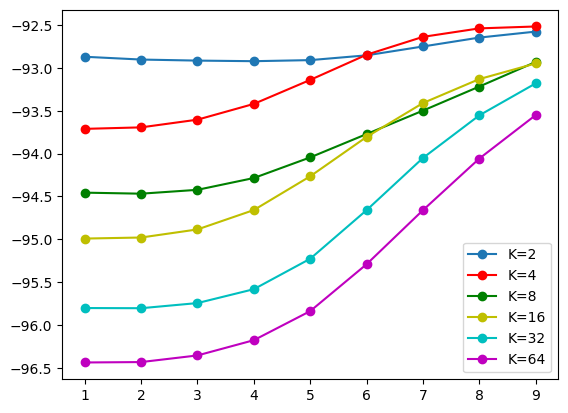

In [24]:
import matplotlib.pyplot as plt

K = [1,2,3,4,5,6,7,8,9]
#qq2 = [-161.0451680919956, -92.8692148077516, -92.90184287107718, -92.9140712949772, -92.92095045113666, -92.90848074694809, -92.85254316586898, -92.7491268474077, -92.64533822278612, -92.57541059752916]
#qq4 = [-160.94172916640338, -93.71103394050206, -93.6935933802939, -93.60354512332684, -93.41959445343907, -93.13938535214984, -92.84529490437043, -92.63695370019552, -92.53789297452757, -92.51566499924733]
#qq8 = [-160.83833937871887, -94.45578746437917, -94.46784206259161, -94.4227353957365, -94.28485921571891, -94.04403975480399, -93.77177954836544, -93.49811292653821, -93.21690185031063, -92.93027700351881]
#qq16 = [-161.23739022292466, -94.99187811778201, -94.97954323763781, -94.88505651355023, -94.65879325670788, -94.26476081337513, -93.80493963313891, -93.40965768494837, -93.12978274100249, -92.94724871162613]
#qq32 = [-161.0881229665554, -95.80296306166122, -95.80495759049919, -95.7449323800002, -95.58282598483837, -95.22743014164435, -94.66016768763507, -94.05085006352745, -93.55308313979877, -93.17988299231584] #, -92.93887621119232]
#qq64 = [-160.91802415809477, -96.43855624588926, -96.4337385756149, -96.35627004745139, -96.17817473728513, -95.83887024895542, -95.29159881312604, -94.66044114357084, -94.0576907485904, -93.55032665656907]

qq2 = [-92.8692148077516, -92.90184287107718, -92.9140712949772, -92.92095045113666, -92.90848074694809, -92.85254316586898, -92.7491268474077, -92.64533822278612, -92.57541059752916]
qq4 = [-93.71103394050206, -93.6935933802939, -93.60354512332684, -93.41959445343907, -93.13938535214984, -92.84529490437043, -92.63695370019552, -92.53789297452757, -92.51566499924733]
qq8 = [-94.45578746437917, -94.46784206259161, -94.4227353957365, -94.28485921571891, -94.04403975480399, -93.77177954836544, -93.49811292653821, -93.21690185031063, -92.93027700351881]
qq16 = [-94.99187811778201, -94.97954323763781, -94.88505651355023, -94.65879325670788, -94.26476081337513, -93.80493963313891, -93.40965768494837, -93.12978274100249, -92.94724871162613]
qq32 = [-95.80296306166122, -95.80495759049919, -95.7449323800002, -95.58282598483837, -95.22743014164435, -94.66016768763507, -94.05085006352745, -93.55308313979877, -93.17988299231584] #, -92.93887621119232]
qq64 = [-96.43855624588926, -96.4337385756149, -96.35627004745139, -96.17817473728513, -95.83887024895542, -95.29159881312604, -94.66044114357084, -94.0576907485904, -93.55032665656907]


plt.plot(K, qq2, '-o', label='K=2')
plt.plot(K, qq4, '-o',color='r', label='K=4')
plt.plot(K, qq8, '-o',color='g', label='K=8')
plt.plot(K, qq16, '-o',color='y', label='K=16')
plt.plot(K, qq32, '-o',color='c', label='K=32')
plt.plot(K, qq64, '-o',color='m', label='K=64')

plt.legend()



 
# To show the plot
plt.show()

In [1]:
import gca_math
import sys

sys.path.insert(0, '/home/mariel/dcaplda-repo/DCA-PLDA')
import dca_plda.calibration as calibration
import dca_plda.scores as scr

f1 = gca_math.fCMLG(score,key)
f2 = gca_math.fCMLG2(score,0.01165722, 6.88764874, -8.03008868)

#print(f1)
#print(f2)

import seaborn as sns
sns.displot(f1, bins=82, kde=True)
sns.displot(f2, bins=82, kde=True)
sns.displot(score, bins=82, kde=True)

tar1, non1 = gca_math.calculate_tar_non(score, key)
tar2, non2 = gca_math.calculate_tar_non(f1, key)
tar3, non3 = gca_math.calculate_tar_non(f2, key)


plda_scrs = scr.Det(tar1, non1)
f1_scrs = scr.Det(tar2, non2)
f2_scrs = scr.Det(tar3, non3)


print('plda_scores: eer=', plda_scrs.eer(), 'act_cllr=', plda_scrs.act_cllr(0.5), 'min_cllr=', plda_scrs.min_cllr(0.5))
print('f1_scores: eer=', f1_scrs.eer(), 'act_cllr=', f1_scrs.act_cllr(0.5), 'min_cllr=', f1_scrs.min_cllr(0.5))
print('f2_scores: eer=', f2_scrs.eer(), 'act_cllr=', f2_scrs.act_cllr(0.5), 'min_cllr=', f2_scrs.min_cllr(0.5))


#logistic regression
logreg_scr = calibration.logregCal(tar1,non1)
lr_scores = logreg_scr(score)

sns.displot(lr_scores, bins=82, kde=True)
tar4, non4 = gca_math.calculate_tar_non(lr_scores, key)

lr_scrs = scr.Det(tar4, non4)

print('lr_scores: eer=', lr_scrs.eer(), 'act_cllr=', lr_scrs.act_cllr(0.5), 'min_cllr=', lr_scrs.min_cllr(0.5))


#sns.displot(tar1, bins=82, kde=True)
#sns.displot(non1, bins=82, kde=True)


#sns.displot(tar1, bins=82, kde=True)
#sns.displot(non1, bins=82, kde=True)



NameError: name 'score' is not defined

gca_scores: eer= 0.026813410222530365 act_cllr= 0.4062347261488344 min_cllr= 0.11045775617438672


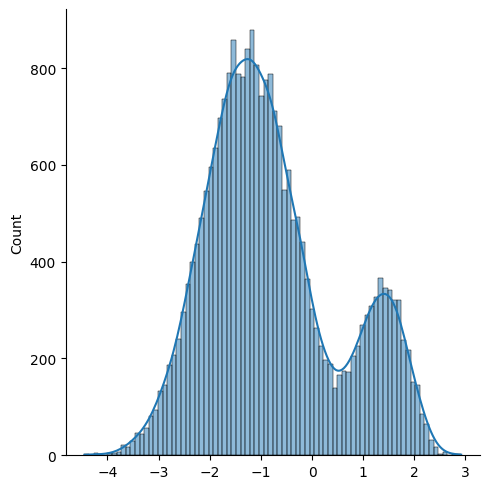

In [5]:
import gca_math
import seaborn as sns
sys.path.insert(0, '/home/mariel/dcaplda-repo/DCA-PLDA')
import dca_plda.calibration as calibration
import dca_plda.scores as scr

gca_score = []

for nn in range(n):
    scrr = gca_math.fGCA(modelparam, score, con, nn)
    gca_score.append(scrr)

sns.displot(gca_score, bins=82, kde=True)

tar5, non5 = gca_math.calculate_tar_non(gca_score, key)

gca_scrs = scr.Det(tar5, non5)

print('gca_scores: eer=', gca_scrs.eer(), 'act_cllr=', gca_scrs.act_cllr(0.5), 'min_cllr=', gca_scrs.min_cllr(0.5))



In [16]:
print(np.exp(np.float128(800)))

2.7263745721125665673e+347
